In this workshop/tutorial we will apply a few explainability approaches to the diabetes dataset from sklearn. 

Structure of the notebook:
- Import libraries and data
- Train simple model
- A transparent less known approach: RuleFit
- Apply visual explanations: ICE plots and PDP plots
- Global surrogate model
- Local explanations: LIME and Shap


### Import libraries and data

In [61]:
#Import libraries

from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pycebox.ice as pice
from sklearn.inspection import plot_partial_dependence
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from rulefit import RuleFit
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap

In [117]:
# Set some pandas options
import matplotlib
matplotlib.rcParams['text.color'] = 'black'
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
raw_data = load_diabetes()
df = pd.DataFrame(np.c_[raw_data['data'], raw_data['target']],
                  columns= np.append(raw_data['feature_names'], ['target']))

Here is a reminder/description of the data, taken from the **sklearn** page(https://scikit-learn.org/stable/datasets/index.html): 

Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

In [5]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.0381,0.0507,0.0617,0.0219,-0.0442,-0.0348,-0.0434,-0.0026,0.0199,-0.0176,151.0000
1,-0.0019,-0.0446,-0.0515,-0.0263,-0.0084,-0.0192,0.0744,-0.0395,-0.0683,-0.0922,75.0000
2,0.0853,0.0507,0.0445,-0.0057,-0.0456,-0.0342,-0.0324,-0.0026,0.0029,-0.0259,141.0000
3,-0.0891,-0.0446,-0.0116,-0.0367,0.0122,0.0250,-0.0360,0.0343,0.0227,-0.0094,206.0000
4,0.0054,-0.0446,-0.0364,0.0219,0.0039,0.0156,0.0081,-0.0026,-0.0320,-0.0466,135.0000


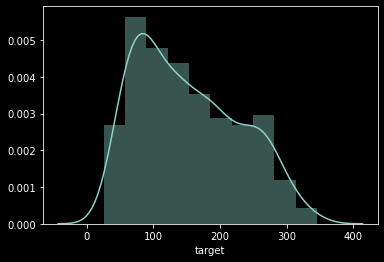

In [7]:
sns.distplot(df['target'])
plt.style.use('dark_background')

In [8]:
df.info() # There are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


<AxesSubplot:>

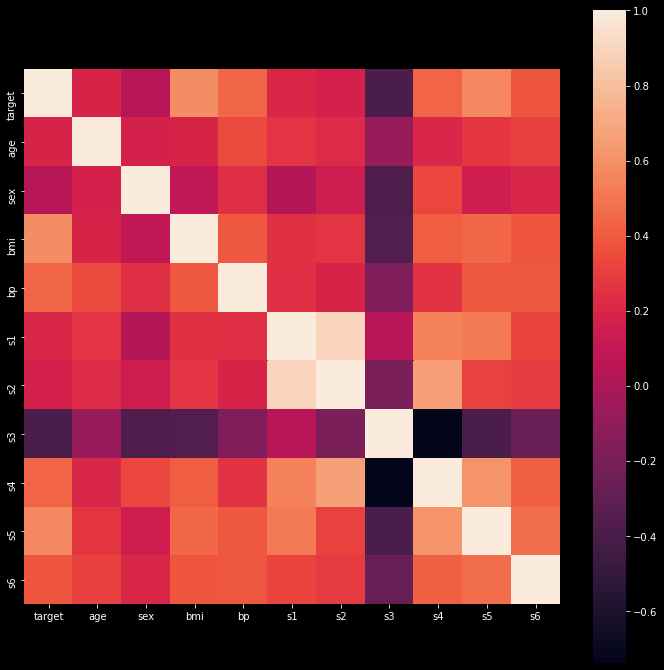

In [9]:
corrmat = pd.concat([df.loc[:, 'target'] ,df.iloc[:, :-1]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
plt.style.use('dark_background')
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

### Train a simple model

In [10]:
y = df.target
X = df.drop('target', axis=1)

In [11]:
# Train a model
clf = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
clf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

<AxesSubplot:>

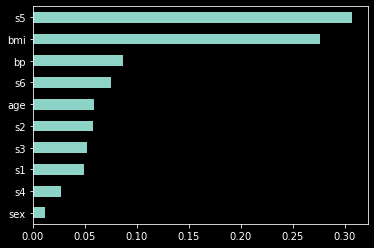

In [12]:
# Print the feature importances, standard after a tree-based model 
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh') 

In [13]:
feat_importances.sort_values(ascending=False).head()

s5    0.3065
bmi   0.2761
bp    0.0866
s6    0.0746
age   0.0587
dtype: float64

In [40]:
# Naive rmse evaluation : note, in reality you have a test set to measure this on
randomf_pred = clf.predict(X)
rmse_randomf = np.sqrt(((randomf_pred - y) ** 2).mean())
print(rmse_randomf)

22.127038659047997


### RuleFit

RuleFit is a transparent type of an algorithm. I am using Chrisoph Molanar's implementation (https://github.com/christophM/rulefit). 

In the first step, we generate sort of decision rules (examples: if x1 > 3 and x2 <5 then 1 else 0). The trees used for the generation of the rules are trained to predict the outcome. You want to generate diverse and meaningful rules. Basically RuleFit generates a new set of features from your original features.

Since this results in many new features being generated, in step 2 you fit a sparse linear model, such as a Lasso, using the original features and the generated rules. So the result is a linear model which will have linear effects for all of the original features and the rules.

Therefore, this is inherently a transparent algorithm but we have enriched the feature space by creating these rules/interactions.

In [25]:
# Create RuleFit
# Default tree_generator is GradientBoosting, but can pass also RandomForest or decision tree
rulefit = RuleFit(tree_generator=RandomForestRegressor(n_estimators = 100))
rulefit.fit(X.values, y, feature_names=X.columns)

RuleFit(Cs=None, cv=3, exp_rand_tree_size=True, lin_standardise=True,
        lin_trim_quantile=0.025, max_rules=2000, memory_par=0.01,
        model_type='rl', random_state=None, rfmode='regress',
        sample_fract='default',
        tree_generator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=4, max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=576, n_jobs=None,
                                             

In [41]:
# What is the rmse of the RuleFit model? 
rulef_prediction = rulefit.predict(X.values)
rmse_rulefit = np.sqrt(((rulef_prediction - y) ** 2).mean())
print(rmse_rulefit)

43.17212018348745


In [27]:
rules = rulefit.get_rules()

rules.head()

,rule,type,coef,support,importance
0,age,linear,-0.0000,1.0000,0.0000
1,sex,linear,-0.0000,1.0000,0.0000
2,bmi,linear,0.0000,1.0000,0.0000
3,bp,linear,4.8766,1.0000,0.2263
4,s1,linear,-0.0000,1.0000,0.0000


The result is a DatFrame where the rows are all the original and extra features, and they are ordered by support, so the original features will be on top, followed by the decision rules. 

Rules are first formed, then a L1 (LASSO) is trained using the rules and the original features. The coef is the coefficient in the Lasso regression. 

Some features are rules, others as linear terms. Type=linear for the original features and type=rule for the rule generated features.

Support is the percentage of data points to which the decision rule applies. For the original features, the support will be 1, for the rule generated ones not, it will be lower. 
 
Feature importances are calculated slightly differently based on whether we have original feature or a rule, and then combining their contribution. 

In [28]:
rules.tail()

,rule,type,coef,support,importance
1289,bmi <= 0.014811381697654724 & s5 > -0.009431487880647182,rule,-0.0000,0.2702,0.0000
1290,bmi <= 0.05576823838055134 & s5 > 0.02095623593777418,rule,0.0000,0.2491,0.0000
1291,bmi <= 0.01319466345012188 & s5 > 0.00661808904260397,rule,-0.0000,0.1985,0.0000
1292,bmi <= 0.005111072678118944 & s5 <= 0.02095623593777418,rule,-0.0000,0.4910,0.0000
1293,s5 > 0.06559612601995468 & bp <= 0.037365272641181946 & s6 <= 0.025845997966825962 & bmi > 0.004033260513097048,rule,0.0000,0.0035,0.0000


In [30]:
# sort by support, i.e. will display original features on top
#rules = rules[rules.coef != 0].sort_values("support", ascending=False) #coef is the lasso coef 
                                                                          
# sort by descreasing feature importance and print 10 most important features
rules1 = rules.sort_values('importance', ascending=False)
for i in range(5):
    print(rules1.iloc[i, 0], ' type:', rules1.iloc[i,1], ' importance:', rules1.iloc[i, -1])

bmi <= 0.02828403189778328 & s2 <= 0.09858047962188721 & s5 <= -0.0037617861526086926  type: rule  importance: 11.735926120087772
bmi > 0.029361844062805176 & bp <= 0.023593789897859097 & bmi > 0.005111072678118944 & s5 <= 0.03634697571396828  type: rule  importance: 9.046076832671472
s5 <= -0.04327875375747681 & s5 <= 0.005796842742711306  type: rule  importance: 7.733721471551048
s2 <= 0.04503209516406059 & bp <= 0.11827273294329643 & bmi <= 0.06870198622345924 & bmi <= 0.0061888848431408405 & s5 <= 0.005796842742711306  type: rule  importance: 6.9773706091721195
bp <= 0.01670804899185896 & bmi <= 0.047145744785666466 & s5 > -0.00016888421669136733 & bmi <= 0.04067887179553509 & bmi > -0.021295323967933655 & sex <= 0.003019241616129875  type: rule  importance: 6.7533014796611655


In [32]:
# Print data sorted by feature importance 
rules1.head(5)

,rule,type,coef,support,importance
671,bmi <= 0.02828403189778328 & s2 <= 0.09858047962188721 & s5 <= -0.0037617861526086926,rule,-23.8194,0.4149,11.7359
404,bmi > 0.029361844062805176 & bp <= 0.023593789897859097 & bmi > 0.005111072678118944 & s5 <= 0.03634697571396828,rule,-32.8986,0.0824,9.0461
951,s5 <= -0.04327875375747681 & s5 <= 0.005796842742711306,rule,-19.9462,0.1843,7.7337
317,s2 <= 0.04503209516406059 & bp <= 0.11827273294329643 & bmi <= 0.06870198622345924 & bmi <= 0.0061888848431408405 & s5 <= 0.005796842742711306,rule,-14.3247,0.3871,6.9774
386,bp <= 0.01670804899185896 & bmi <= 0.047145744785666466 & s5 > -0.00016888421669136733 & bmi <= 0.04067887179553509 & bmi > -0.021295323967933655 & sex <= 0.003019241616129875,rule,25.9743,0.0729,6.7533


We see in row 3, for example, that s5<= -0.043 and s3<=0.005. If the first condition is fulfilled, the second one is automatically fulfilled, too. This is one of the tricky parts of models that create decision rules - creating rules which are sensible and at the same time important and/or predictive.  

Overall, this remains an intersting option for a transparent model, but it's more difficult to evaluate the 'goodness' of the created decision rules.

### Visual approaches

Among the visual explanations we will apply are ICE plots and PDP plots. 

Partial dependency plots shows how the average prediction changes as you change the feature(s) you are plotting. 
Individual independence (ICE) plots are similar to PDP plots but show one line per instance instead of the average. Thus they can uncover heterogeneous effects. 

______________________________________________________________

To plot ICE plots, we will use the **pycebox** package and its **ice** and **ice_plot** functions.

**ice** takes in a dataframe, a column of interest and model object, on which to predict. It returns a DataFrame with ICE curves for a model. The columns are ICE curves with the row index the independent variable (so chosen column) and the column index is the original data point corresponding to that ICE curve. 

To create PDP plots, we can also use the **pycebox** package. However, I will also utilise **sklearn.inspection**.

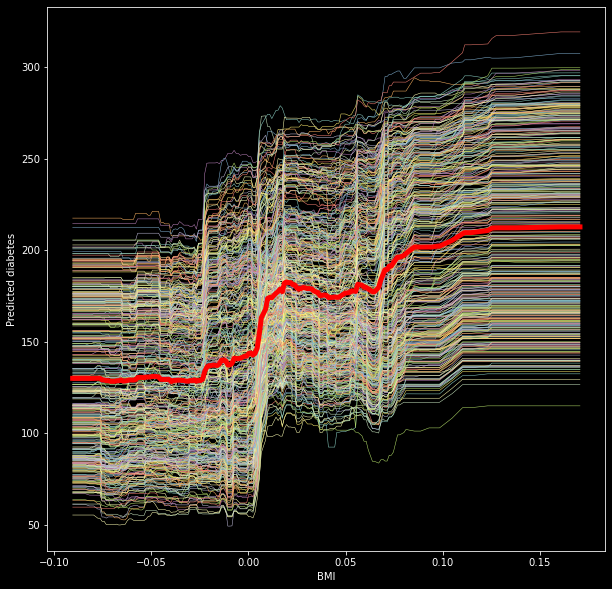

In [62]:
# We feed in the X-matrix, the model and ONE feature at a time 
bmi_ice_df = pice.ice(data=X, column='bmi', 
                   predict=clf.predict)

# Plot the figure
fig, ax = plt.subplots(figsize=(10, 10))
pice.ice_plot(bmi_ice_df, linewidth=.5,  plot_pdp=True, 
         pdp_kwargs={'c': 'red', 'linewidth': 5}, ax=ax)
 
ax.set_ylabel('Predicted diabetes')
ax.set_xlabel('BMI')
fig.savefig('BMI_ICEplot.png')

We may also wonder what does the *bmi_ice_df* look like? From checking it's shape we see that it has as many columns as the rows in the original dataframe, and as many rows as the unique values of that column. So, each row in bmi_ice_df corresponds to each of its unique values, and each column- to each of rows in the original data. 

In [63]:
print(bmi_ice_df.shape)
print(X.bmi.nunique())

(163, 442)
163


The different values of bmi are sorted in ascending order. The columns are the predictions for each instance in the data, having the respective bmi value. 

In [64]:
bmi_ice_df.tail()

data_bmi  -0.0903  -0.0892  -0.0849  -0.0838  -0.0817           -0.0806  \
age       -0.0927  -0.0709  -0.0200  -0.0963  -0.0927  -0.0818  -0.0564   
sex       0.0507   0.0507   -0.0446  -0.0446  -0.0446  -0.0446  -0.0446   
bp        -0.0573  -0.0745  -0.0263  0.0081   -0.0573  -0.0401  -0.0849   
s1        -0.0250  -0.0428  -0.0360  -0.1034  -0.0607  0.0026   -0.0373   
s2        -0.0304  -0.0257  -0.0342  -0.0906  -0.0680  -0.0185  -0.0370   
s3        -0.0066  -0.0324  0.0413   -0.0139  0.0486   0.0707   0.0339    
s4        -0.0026  -0.0026  -0.0517  -0.0764  -0.0764  -0.0395  -0.0395   
s5        0.0241   -0.0129  -0.0824  -0.0629  -0.0665  -0.0109  -0.0562   
s6        0.0031   -0.0549  -0.0466  -0.0342  -0.0218  -0.0922  -0.1378   
bmi                                                                       
0.1274   244.9200 190.4200 146.0800 185.0600 166.7600 166.0800 143.9600   
0.1285   244.9200 190.4200 146.0800 185.0600 166.7600 166.0800 143.9600   
0.1371   244.9200 190.4200 146.0800 185.0600 166.7600 166.0800 143.9600   
0.1609   248.0800 190.4200 146.0800 185.0600 166.7600 166.0800 143.9600   
0.1706   248.0800 190.4200 146.0800 185.0600 166.7600 166.0800 143.9600   

data_bmi  -0.0795  -0.0773           -0.0763  -0.0752  -0.0741  -0.0730  \
age       -0.0636  -0.1072  -0.0745  -0.0963  -0.0709  -0.0564  -0.0782   
sex       0.0507   -0.0446  0.0507   -0.0446  0.0507   -0.0446  -0.0446   
bp        -0.0057  -0.0263  -0.0470  -0.0435  -0.0401  -0.0504  -0.0573   
s1        -0.0717  -0.0896  -0.0470  -0.0456  -0.0511  -0.0250  -0.0841   
s2        -0.0664  -0.0962  -0.0326  -0.0348  -0.0151  -0.0470  -0.0743   
s3        -0.0103  0.0266   0.0045   0.0081   -0.0397  0.0928   -0.0250   
s4        -0.0395  -0.0764  -0.0395  -0.0395  -0.0026  -0.0764  -0.0395   
s5        -0.0181  -0.0426  -0.0721  -0.0595  -0.0964  -0.0612  -0.0181   
s6        -0.0549  -0.0052  -0.0176  -0.0839  -0.0342  -0.0466  -0.0839   
bmi                                                                       
0.1274   196.1800 180.0800 156.8400 158.8400 165.3200 136.3000 184.9800   
0.1285   196.1800 180.0800 156.8400 158.8400 165.3200 136.3000 184.9800   
0.1371   196.1800 180.0800 156.8400 158.8400 165.3200 136.3000 184.9800   
0.1609   196.1800 180.0800 156.8400 158.8400 165.3200 136.3000 184.9800   
0.1706   196.1800 180.0800 156.8400 158.8400 165.3200 136.3000 184.9800   

data_bmi           -0.0720  -0.0709  -0.0698                    -0.0687  \
age       -0.0455  0.0126   0.0018   -0.0963  -0.0237  -0.0019  0.0562    
sex       -0.0446  0.0507   -0.0446  -0.0446  -0.0446  -0.0446  -0.0446   
bp        -0.0814  -0.0470  -0.0229  -0.0676  -0.0642  -0.0126  -0.0688   
s1        0.0837   -0.0511  -0.0016  -0.0195  -0.0594  -0.0002  -0.0002   
s2        0.0278   -0.0971  -0.0010  -0.0107  -0.0505  -0.0091  -0.0010   
s3        0.1738   0.1186   0.0266   0.0155   0.0192   0.0707   0.0450    
s4        -0.0395  -0.0764  -0.0395  -0.0395  -0.0395  -0.0395  -0.0376   
s5        -0.0042  -0.0203  -0.0225  -0.0469  -0.0891  -0.0629  -0.0484   
s6        0.0031   -0.0384  0.0072   -0.0798  -0.0508  0.0403   -0.0011   
bmi                                                                       
0.1274   170.7400 159.8200 157.7000 147.8000 148.3800 147.5600 132.4800   
0.1285   170.7400 159.8200 157.7000 147.8000 148.3800 147.5600 132.4800   
0.1371   170.7400 159.8200 157.7000 147.8000 148.3800 147.5600 132.4800   
0.1609   170.7400 159.8200 157.7000 147.8000 148.3800 147.5600 132.4800   
0.1706   170.7400 159.8200 157.7000 147.8000 148.3800 147.5600 132.4800   

data_bmi  -0.0676  -0.0666                    -0.0655                    \
age       -0.1000  -0.0418  -0.0273  -0.0019  -0.0418  -0.0237  -0.0128   
sex       -0.0446  -0.0446  -0.0446  -0.0446  -0.0446  -0.0446  -0.0446   
bp        -0.1090  -0.0470  -0.1124  0.0012   -0.0401  -0.0814  -0.0699   
s1        -0.0745  -0.0373  -0.0497  -0.0029  -0.0057  -0.0387  0.0012    
s2        -0.0727  -0.

We can also center the ICEplot, so that all lines start from the same point, i.e. remove level effects and make the figure more readable. 

Text(0.5, 0, 'BMI')

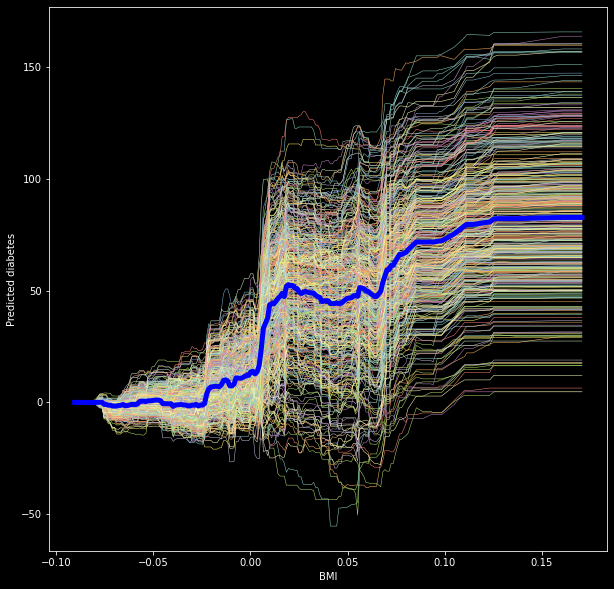

In [65]:
# There is an error in the __gen_quantiles() in the ice_plot, patch it below: 
def __get_quantiles(x):
    return np.greater.outer(x, x).sum(axis=1) / x.size
pice.__get_quantiles = __get_quantiles

# Plot the centered figure
fig, ax1 = plt.subplots(figsize=(10, 10))
pice.ice_plot(bmi_ice_df, linewidth=.5,  plot_pdp=True, 
         pdp_kwargs={'c': 'blue', 'linewidth': 5}, centered=True, ax=ax1)
 
ax1.set_ylabel('Predicted diabetes')
ax1.set_xlabel('BMI')

In [17]:
fig.savefig('BMI_ICEcentered.png')

The above plot is definitely more readable. Let's explore another feature. According to the feature importance after the random forest model *s5* is the most important feature. This is one of the features measuring the blood serum. 

Text(0.5, 0, 'S5')

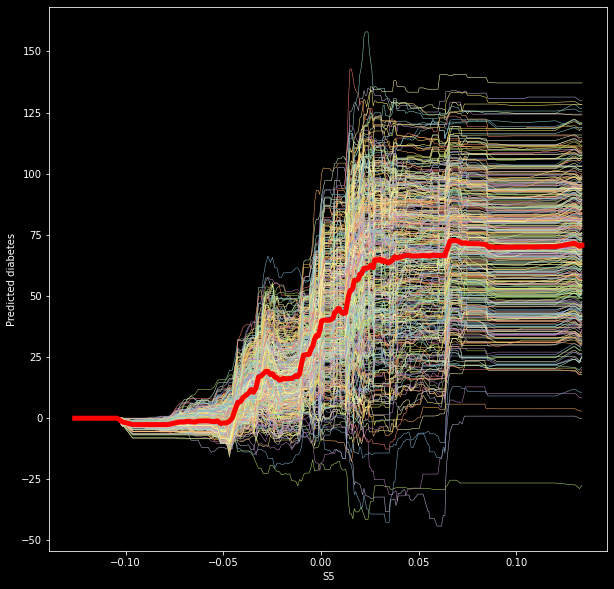

<Figure size 1080x1080 with 0 Axes>

In [66]:
s5_ice_df = pice.ice(data=X, column='s5', 
                   predict=clf.predict)

# Plot the figure
fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(figsize=(15, 15))
pice.ice_plot(s5_ice_df, linewidth=.5,  plot_pdp=True, centered=True,
         pdp_kwargs={'c': 'red', 'linewidth': 5}, ax=ax)
 
ax.set_ylabel('Predicted diabetes')
ax.set_xlabel('S5')

In [19]:
fig.savefig('s5_centeredICE.png')

### PDP plots

I will first work with the **sklearn.inspection** package. We can select a single feature to plot, a couple of features, or even create an interaction between 2 feature. We can have an interaction plot of 2 features at a time, not more. 

**Note:** in scikit-learn 0.23 or later, one can specify argument *kind* in the partial_dependence_function. When it is set to *both*, then the plot will display both the PDP and the corresponding ICE plots. In this version of sklearn that I have that argument does not work yet. 

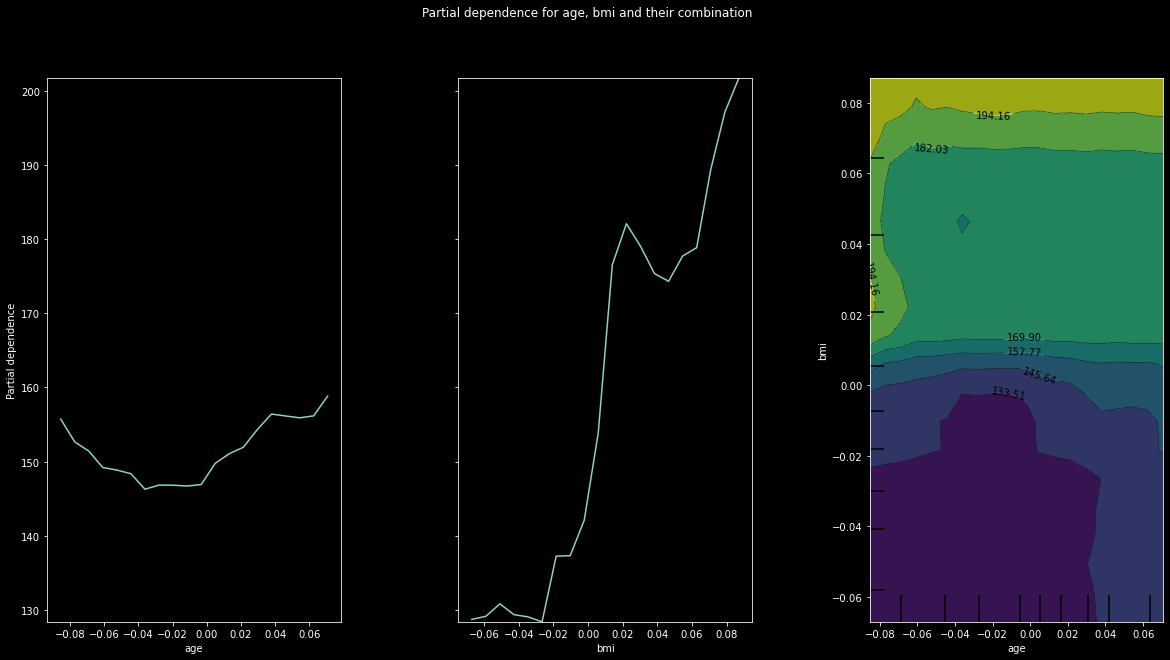

In [59]:
# Define features to include in the plots
# One can identify single feature, or a combination of features, given as a tuple
features = ['age', 'bmi', ('age', 'bmi')]

fig, ax = plt.subplots(figsize=(20, 10))
plot_partial_dependence(estimator=clf, target=y,
                        X=X, #raw features data
                        features=features, fig=fig, grid_resolution=20) #columns we want to show
                                                
fig.suptitle('Partial dependence for age, bmi and their combination')
fig.subplots_adjust(wspace=0.4, hspace=0.3)

In [60]:
# If you want to inspect all the arguments of the function
#help(plot_partial_dependence)

In [21]:
fig.savefig('PDP_plot_bmi_age.png')

Anoter alternative is to continue working with the **pycebox** package and choose the **pdp** function. 

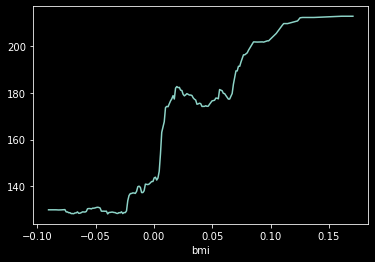

In [40]:
icebox.pdp(bmi_ice_df).plot()
plt.savefig('PDP_bmi_pycebox.png')

Looks very similar but it's less clear to me how one may do a PDP with interactions using the *pycebox* package. 

There are other packages to plot partial dependence in Python (such as PDPbox). PDPbox enriches icebox (Pycebox is often just called icebox since it was inspired by the ICEbox package in R) by, for example: supporting one-hote encoding of features, suppport 2-variable interaction plots, and better handling of multi-class classification problems.

### Global surrogate model

Global surrogate models are quite straightforward. In this approach, we fit an interpretable model (such as a decision tree estimator or a linear/logistic regression) after the black box model. The one important factor we need to keep track of is how well the surrogate approximates the black box model. 

Also, note that the interpretable model we train needs to be relatively simple. If we fit a very complex and large tree after a gradient boosting model, for example, we gain little in terms of explainability. 

In [67]:
predictions = clf.predict(X)
dt = DecisionTreeRegressor(random_state = 100, max_depth=3)
# We fit the shallow tree to the matrix X and the predictions of the random forest model 
dt.fit(X, predictions)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=100, splitter='best')

[Text(558.0, 475.65000000000003, 's5 <= -0.004\nmse = 4055.893\nsamples = 442\nvalue = 152.345'),
 Text(279.0, 339.75, 'bmi <= 0.006\nmse = 1793.689\nsamples = 218\nvalue = 111.426'),
 Text(139.5, 203.85000000000002, 's3 <= 0.025\nmse = 965.478\nsamples = 171\nvalue = 97.992'),
 Text(69.75, 67.94999999999999, 'mse = 1193.493\nsamples = 91\nvalue = 108.497'),
 Text(209.25, 67.94999999999999, 'mse = 437.788\nsamples = 80\nvalue = 86.042'),
 Text(418.5, 203.85000000000002, 'bp <= 0.024\nmse = 1761.652\nsamples = 47\nvalue = 160.3'),
 Text(348.75, 67.94999999999999, 'mse = 1151.053\nsamples = 32\nvalue = 147.762'),
 Text(488.25, 67.94999999999999, 'mse = 2013.367\nsamples = 15\nvalue = 187.049'),
 Text(837.0, 339.75, 'bmi <= 0.015\nmse = 3041.966\nsamples = 224\nvalue = 192.169'),
 Text(697.5, 203.85000000000002, 'bmi <= -0.023\nmse = 2042.661\nsamples = 116\nvalue = 162.802'),
 Text(627.75, 67.94999999999999, 'mse = 1386.356\nsamples = 41\nvalue = 140.916'),
 Text(767.25, 67.94999999999999, 'mse = 1996.426\nsamples = 75\nvalue = 174.767'),
 Text(976.5, 203.85000000000002, 'bmi <= 0.069\nmse = 2194.031\nsamples = 108\nvalue = 223.712'),
 Text(906.75, 67.94999999999999, 'mse = 1940.624\nsamples = 77\nvalue = 208.316'),
 Text(1046.25, 67.94999999999999, 'mse = 772.354\nsamples = 31\nvalue = 261.953')]

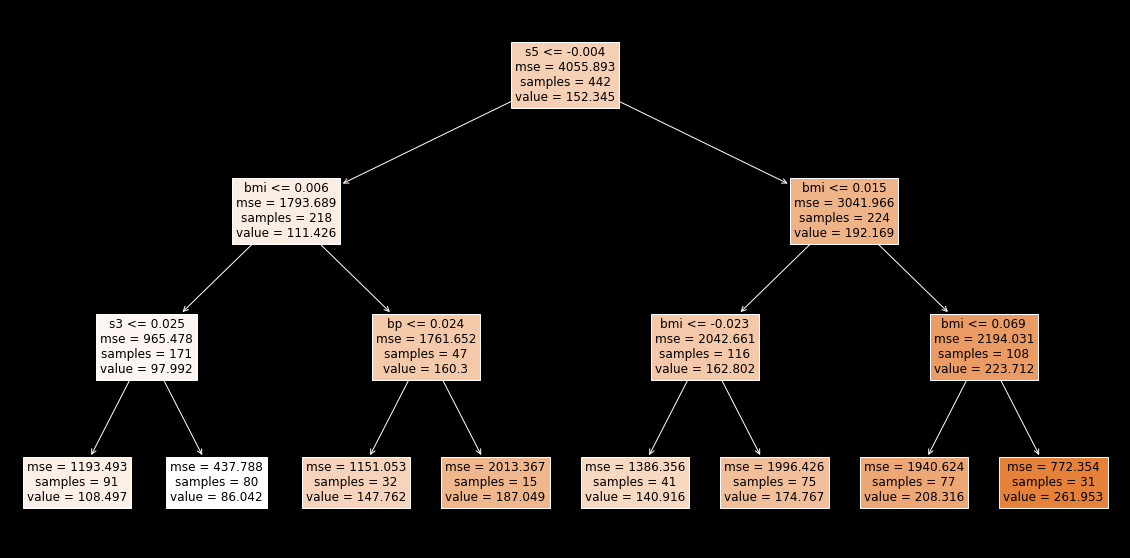

In [69]:
fig, ax = plt.subplots(figsize=(20, 10))

plot_tree(dt, feature_names=list(X.columns), precision=3, 
           filled=True, fontsize=12, impurity=True)

In [32]:
fig.savefig('surrogate_tree.png')

We need to keep track of how well the surrogate model approximates the black box model. One goos way to do that is to keep track of the R-squared for example. 

In [70]:
dt.score(X, predictions)

0.6705488147404473

It's unclear though whether this R-squared is high/good enough-- and this is one of the difficulties of surrogate models, deciding what is a good approximation.

### Local explanations

Among two of the most popular approaches for providing local explanations (i.e. explanaing the decision of the model for each instance in the data), are LIME and Shapley values. 

#### LIME

LIME: 1 ) generates a new dataset of permuted samples and corresponding predictions of the black box model; 2) trains an interpretable model on the new dataset, weighted by the proximity of the sampled instances to the instance of interest

It works on both regression and classification problems as well as with tabular data, text and images.

There are a couple of libraries that implement LIME. I will use the  **lime** package.

An alternative is the *eli5* package. I stick to the lime package since it's also written by the original authors of the LIME paper. 

In [109]:
# Define a Lime explainer
explainer = LimeTabularExplainer(X, mode='regression', 
                                 feature_names=list(X.columns), 
                                 random_state=42, 
                                 discretize_continuous=False,
                                 kernel_width=2) 

In [92]:
#help(LimeTabularExplainer)

Note that the local explanation is not dependent on the black box model -- we did not specify it anywhere yet. An important parameter could be the kernel_width. Modifications could results in varying results. Remember that the algorithm uses exponential smooting kernel to define a neighborhood around an instance. 

In [110]:
# Generate explanations for the i-th row in the dataset: change the X.loc[] to change which row you select
# Can also select the number of features to use for that explanation, given by num_features

exp = explainer.explain_instance(X.iloc[0,:].values, 
                                 clf.predict, num_features=5)

In [111]:
exp.local_pred

array([202.84488682])

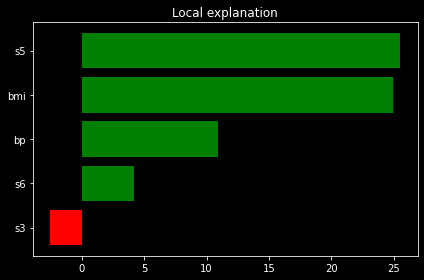

In [112]:
# We can also print the explantions for this instance
exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig('Lime_example.png')

In [113]:
# This does not render well in dark background obviously. Solution is change the background, or save as html 
# if you want to use it elsewhere

exp.show_in_notebook(show_table=True)

In [114]:
# Or we can print them as a list
print(exp.as_list())

[('s5', 25.497683714025246), ('bmi', 24.95685648553382), ('bp', 10.94615534217599), ('s6', 4.2139938692073855), ('s3', -2.505238502061392)]


We can see that the explanations for the same observation will change substantially with the kernel_width, for example, and/or the number of features we want to include in the explantion (which is to be expected).


This is my difficuly with LIME - there is no guidance on what would be correct kernel setting, and/or how many features you want to include there for each instance in the data. If we already had an intuition about it, we most likely would not have built a complex model to make such a prediction. 

### Shapley values

The Shapley values calculate the marginal contribution of each feature on an instance level compared to the average prediction for the data set. It also works on classification and regression tasks, as well as on tabular, text and images.

It includes all of the features for each instance and ensure fair distriburion of the contributions of the features. 

I will work with the  **shap** package. I don't think there is another establish package for Shapley values in Python.

Since I have trained a random forest model, the TreeShap would be the most appropriate approach (also since it was proposed as a faster alternative to KernelShap).

In [115]:
# explain the model's predictions using SHAP values
# This is the part that can take a while to compute with larger datasets

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

We can look at the Shapley values for one instance. We see how each feature's contribution is pushing the model's output from the base value to the model output for the concrete instance. In red are features that increase the contribution, and in blue- are those that decrease. We see the concrete values of the features for that one instance (below), and their contribution. 

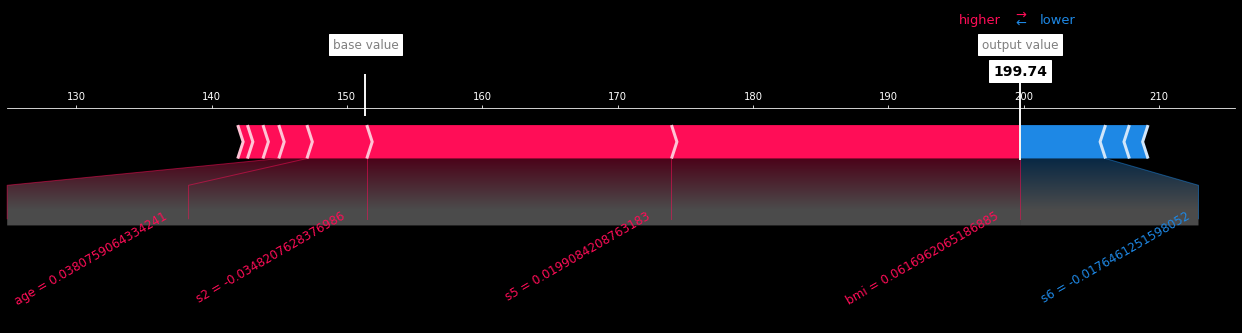

<Figure size 432x288 with 0 Axes>

In [118]:
# load JS visualization code to notebook
shap.initjs()

plt.style.use("_classic_test_patch")  

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True, figsize=(22, 4), \
                text_rotation=30)

plt.savefig('Shapley_1st_row.png')

In [119]:
# Perhaps the exact values are not readable from the plot, we can extract them in a table 
shap_vals = shap_values[0, :]
feature_importance = pd.DataFrame(list(zip(X.columns, shap_vals)), columns=['column_value','shap_vals'])
feature_importance.sort_values(by=['shap_vals'], ascending=False,inplace=True)
feature_importance

,column_value,shap_vals
2,bmi,25.7641
8,s5,22.5078
5,s2,4.4226
0,age,2.0797
3,bp,1.1667
6,s3,1.1460
4,s1,0.7180
7,s4,-1.3802
1,sex,-1.7603
9,s6,-6.2965


We can also extract Shap feature importances - where features with large Shapley values are considered important. Since we want global importances, we average the absolute Shapley values per feature across the data (sorted by decreasing order of importance).

The Shap feature importances is an alternative to the permutation (traditional) feature importance. 

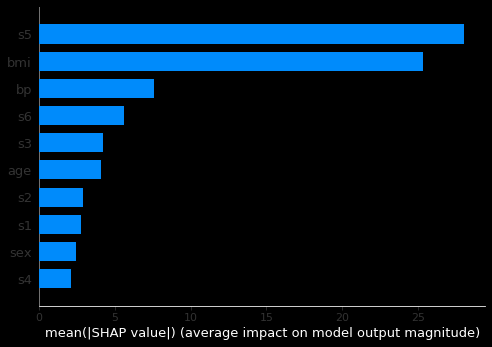

In [120]:
# Plot the features'average impact on the model output's magnitude
shap.summary_plot(shap_values, X, plot_type="bar")

We can combine feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

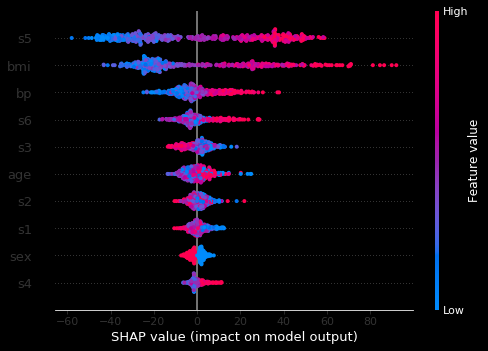

<Figure size 432x288 with 0 Axes>

In [121]:
# summarize the effects of all the features

shap.summary_plot(shap_values, X)
plt.savefig('shapley_vals.png')

We can also plot a Shapley dependence plots. They are very intuitive. We pick a feature and for each instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis. We can think of them as an alternative to Partial dependency plots but instead of showing average effect, we also see variance in the y-axis.  

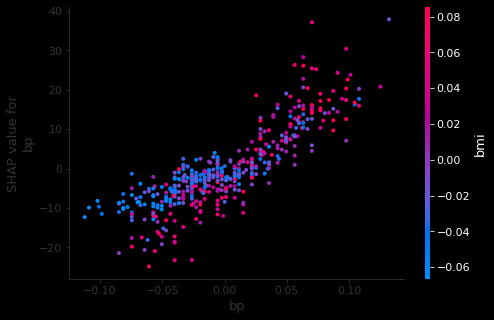

In [125]:
# The first argument is the feature of interest as an integer or string, followed by the shap_values and X matrix
shap.dependence_plot(3, shap_values, X)

The color corresponds to a second feature, which may have an interaction effect with the feature of interest (it is chosen automatically). If there is an interaction effect, it will show up as a distinct vertical pattern of coloring. 
For instance, this plot indicates that those with bp of around -0.05 and lower bmi have worse predicted outcome than those with bp of around -0.05 and higher bmi (which may contradict intuition). This all cound indicate a possible interaction effect. 